## Labeled Data Generation Using Madagascar
The objective of this exercise is to train a neural network to output the frequency of a sample.
To accomplish this, we need a number of labeled data samples of different frequencies.

In [1]:
%%file SConstruct
from rsf.proj import *
import random as rnd

# seed random number generator
rnd.seed(1)

# randomly generating cosine samples for a regression problem

# identifier for this experiment
experiment_name = 'frequency-regression'

# unique labelers for ml experiments

# this says what frequency it is
# for our problem, this will be a float
ml_value  = 'ml_value'  

# minimum frequency
fmin = 15
# maximum frequency
fmax = 60
# how many random frequencies?
nfreq = 51

# how many samples will we want our learning inputs to be?
lrnspl = 128
# and how many learning samples per trace?
nspl = 1
# model parameters
n1 = lrnspl*nspl
d1 = 0.004
o1 = 0
n2 = 11
d2 = 0.1
o2 = 0


# noise mean
meanlst = [0,.1,.25]
# noise range
rangelst = [0,.1,.25]
# noise variance
varlst = [0,.1,.25]
# noise type (normal/uniform)
typelst = ['y']

# list of all files generated here
filelst = []
# list of frequencies
freqlst = []
# loop throgh frequencies
for f in range(nfreq):
    # What's the frequency, Kenneth?
    freq = rnd.random()*(fmax-fmin) + fmin
    # record the frequency
    freqlst.append(freq)
    # create cosine waves with that frequency
    cosines = experiment_name+'-cos-%i'%f
    Flow(cosines,None,
        '''
        math n1=%i d1=%g o1=%g
        n2=%i d2=%g o2=%g
        math output="cos(x1/%g+x2/%g)"
        '''%(n1,d1,o1,n2,d2,o2,1/(freq*(2*3.14)),(2*3.14)/(d2*(n2-1))))
    
    # loop through noise parameters and add to the convolved traces
    for m in range(len(meanlst)):
        # get noise mean
        noisemean = meanlst[m]
        mean = cosines+'-%i'%m
        for r in range(len(rangelst)):
            # get noise range
            noiserange = rangelst[r]
            rang = mean+'-%i'%r
            for v in range(len(varlst)):
                # get noise variance
                noisevar = varlst[v]
                var = rang+'-%i'%v
                for t in range(len(typelst)):
                    noisetype = typelst[t]
                    Flow(var,cosines,
                       '''
                       noise mean=%g range=%g 
                       var=%g type=%s
                       '''%(noisemean,noiserange,noisevar,noisetype))
                    # output the noised traces with frequency labels
                    for i2 in range(n2):
                        # identifier for this trace
                        trac = var+'-%i'%i2
                        # what part of the trace
                        for i1 in range(nspl):
                            part = trac+'-%i'%i1
                            # window out trace, put identifier
                            # the put command will place the ml classification info
                            # in the .rsf file's header info to make it easier to 
                            # use later during tensorflow operations
                            Flow(part,var,
                               '''
                               window n2=1 f2=%i n1=%i f1=%i| 
                               put %s=%g
                               '''%(i2,lrnspl,lrnspl*i1,
                                    ml_value,freq))
                            # add this file to the filest
                            filelst.append(part+'.rsf')
                            
# write out the list of all files
with open(experiment_name+'-files.txt','w') as filehandle:
    for example in filelst:
        filehandle.write('%s\n'%example)               
            
# write out the list of frequencies corresponding to each bin
with open(experiment_name+'-labels.txt','w') as filehandle:
    for f in range(len(freqlst)):
        filehandle.write('label=%i\ttype=%g\n'%(f,freqlst[f]))
End()

Overwriting SConstruct


In [2]:
# run the SConstruct that we have written to file
import os
os.system('pscons')

0

## Machine Learning Portion

In [2]:
# relevant imports
import numpy as np
import tensorflow as tf
import m8r
import os
import random as rnd
import matplotlib.pyplot as plt
%matplotlib inline
# test if gpu working
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")
# seed for assigning testing and training
rnd.seed(1)

Default GPU Device:/device:GPU:0


In [3]:
def read_and_label(filedir, ml_value_name_string="ml_value"):
    # function for reading a rsf file, 
    # determinging its machine learning label, 
    # and outputting its sampling
    inp = m8r.Input(filedir)
    # file sampling
    n1 = inp.int("n1") # this is equal to 128 in our example
    n2 = inp.int("n2") # this is equal to 1 in our example
    N = [n2,n1] # adding an extra dummy dimension
    # read data
    data = inp.read(shape=N)
    # regression for ml problem
    ml_value= inp.float(ml_value_name_string) # class name for this class
    return data, ml_value, N

In [4]:
# experiment name, this should match the name in the SConstruct file above
experiment_name = 'frequency-regression'
# current working directory
cwd = os.getcwd()
# directory with the examples (in this case the current working directory)
exdir = cwd
# name of file with the list of examples
exfile = experiment_name+'-files.txt'

In [5]:
# open the list of example files, convert to a list
filelst = []
with open (exdir+'/'+exfile,'r') as filehandle:
    filelst = [current_place.rstrip() for current_place in filehandle.readlines()]

In [6]:
# shuffle the file list so we don't clump our classes together 
rnd.shuffle(filelst)

# portion of data for testing ?
testfrac = 0.1

# flags for if our trainining and testing datasets have begun
beguntest = False
beguntrain = False

# initialize the labels array by reading the first element
temp_data, temp_ml_classname, temp_N,  = read_and_label(exdir+'/%s'%filelst[0])

# loop through file list, read data and associated values
for example in filelst:    
    temp_data, temp_ml_value, temp_N = read_and_label(exdir+'/%s'%example)
    # transform the ml type into a 1x1 array for concactonation
    temp_ml_value = np.array([[temp_ml_value]])
    # call random number, are we abbove or below?
    if rnd.random() < testfrac:
        # have we initialized the numpy arrays?
        if beguntest:
            dataarray_test = np.concatenate((dataarray_test,temp_data),axis=0)
            labelarray_test = np.concatenate((labelarray_test,temp_ml_value),axis=0)
        else:
            dataarray_test = temp_data
            labelarray_test = temp_ml_value
            beguntest = True
    else:
        # have we initialized the numpy arrays?
        if beguntrain:
            dataarray_train  = np.concatenate((dataarray_train,temp_data),axis=0)
            labelarray_train = np.concatenate((labelarray_train,temp_ml_value),axis=0)
        else:
            dataarray_train = temp_data
            labelarray_train = temp_ml_value
            beguntrain = True



In [7]:
# reshape arrays for tf compatibility, adding dummy 3rd dimension and 2nd dimension 
dataarray_train = np.reshape(dataarray_train,[dataarray_train.shape[0],temp_N[0],temp_N[1]])
dataarray_test = np.reshape(dataarray_test,[dataarray_test.shape[0],temp_N[0],temp_N[1]])

In [8]:
# turn our numpy arrays into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dataarray_train, labelarray_train))
test_dataset  = tf.data.Dataset.from_tensor_slices((dataarray_test , labelarray_test ))

In [9]:
# shuffle and batch the datasets
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE=100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset  = test_dataset.batch(BATCH_SIZE)

In [10]:
# build a model
model = tf.keras.Sequential([
            tf.keras.layers.Reshape((temp_N[1],1), input_shape=(1,temp_N[1],)),
            tf.keras.layers.Conv1D( filters=64, kernel_size=32, activation='relu',input_shape=(temp_N[1],1)),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Dense(16,activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1) # output is the dimension of the number of frequency classes
        ])
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 128, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 97, 64)            2112      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 48, 64)            0         
_________________________________________________________________
dense (Dense)                (None, 48, 16)            1040      
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 769       
Total params: 3,921
Trainable params: 3,921
Non-trainable params: 0
______________________________________________________

In [11]:
# fit the model
model.fit(train_dataset, epochs=10)

Train for 214 steps
Epoch 1/10
214/214 [==============================] - 2s 11ms/step - loss: 211.4910 - mean_squared_error: 212.3099
Epoch 2/10
214/214 [==============================] - 1s 5ms/step - loss: 5.3447 - mean_squared_error: 5.3605
Epoch 3/10
214/214 [==============================] - 1s 5ms/step - loss: 3.1709 - mean_squared_error: 3.1813
Epoch 4/10
214/214 [==============================] - 1s 5ms/step - loss: 2.5112 - mean_squared_error: 2.5158
Epoch 5/10
214/214 [==============================] - 1s 5ms/step - loss: 2.1171 - mean_squared_error: 2.1156
Epoch 6/10
214/214 [==============================] - 1s 5ms/step - loss: 1.8279 - mean_squared_error: 1.8248
Epoch 7/10
214/214 [==============================] - 1s 5ms/step - loss: 1.5125 - mean_squared_error: 1.5160
Epoch 8/10
214/214 [==============================] - 1s 5ms/step - loss: 1.2609 - mean_squared_error: 1.2578
Epoch 9/10
214/214 [==============================] - 1s 5ms/step - loss: 1.0182 - mean_squared

In [12]:
# evaluate the accuracy on the training dataset
train_predict = model.predict(train_dataset)
# calculate mse
train_mse = np.mean(tf.keras.losses.MSE(labelarray_train,train_predict))
print('\nTrain MSE: ',train_mse)

# evaluate the accuracy on the testing dataset 

test_predict = model.predict(test_dataset)
# calculate test dataset mse
test_mse = np.mean(tf.keras.losses.MSE(labelarray_test,test_predict))

print('\nTest MSE:', test_mse)


Train MSE:  359.68338

Test MSE: 0.85918725


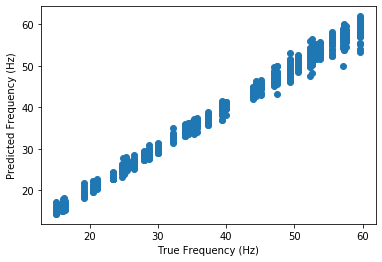

In [16]:
# make a scatter plot comparing the predicted frequencies and true frequencies
plt.scatter(labelarray_test,test_predict)
plt.ylabel("Predicted Frequency (Hz)")
plt.xlabel("True Frequency (Hz)")
plt.show()

In [14]:
# define a function for visualizing some results
def plotelement(i,true_label_array,predicted_label_array):  
    plt.ylabel('True Frequency is %g'%true_label_array[i])
    plt.xlabel('Predicted Frequency is %g'%predicted_label_array[i])
    plt.plot(dataarray_test[i,0,:])
    plt.show()
    return

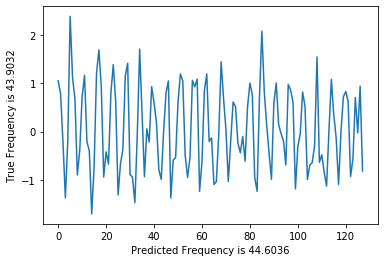

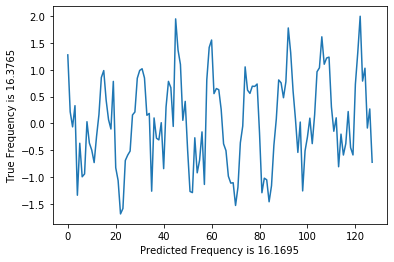

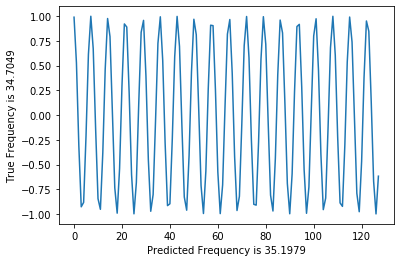

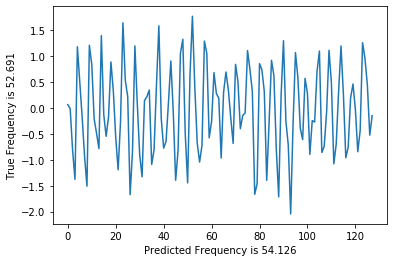

In [15]:
# make a list of test elements to visualize
elelst=[1,20,35,10]
for e in elelst:
    plotelement(e,labelarray_test,test_predict)